# Data Science Internship Interview Task

Author: Graydon Cedric Elkouh

Last updated: August 15, 2021

Running my code: For my code in this notebook to run on your machine, the only thing you need to change is the file path of `image_folder` below to reflect the location of the Images folder on your computer.

In [1]:
image_folder = '/Users/gelkouh/Desktop/Images'

## Strategy and organization

What we know:
+ Each image displays three types of terrain/objects: 
    1. Road
    2. Building
    3. Vegetation cover and empty space
+ Each image has dimensions of 640 x 500 pixels (note that, going forward, **any measurement of distance is in units of pixels**) 
+ The midpoint of each image is considered the location of a shop when it is within the bounds of a building
+ When the midpoint is within the bounds of a building, we consider the front side of the shop to be the side of the building to which the midpoint is closest 

What we want to know: 
+ The distance from the front side of the shop to the nearest road or building in the same direction (we will call this the common case)

BUT, the midpoint is not within the bounds of a building in all of the images. This presents two edge cases:
1. Edge case 1: **The midpoint is in a road, in which case we will consider the distance to be 0**
2. Edge case 2: The midpoint is in vegetation cover or empty space, in which case we will consider the distance to be the distance from the midpoint itself to the nearest road or building (not that **the Flag variable we output indicates whether it is a road or building the midpoint is closest to**)

The rest of this notebook is organized into sections in the following order to first address the two edge cases and the common case, then to present a main function that simply accepts an image and outputs **Image_name, Distance, Flag**, as desired:
1. Edge case 1: Midpoint is already in a road
2. Edge case 2: Midpoint is not in a building, but not in a road
3. Common case: Midpoint is in a building
4. Main function and output

## Note about accuracy and sources of error

The approach I took of identifying the distance between edge pixels (i.e., pixels that form the edges of road and buildings), introduces some error into the output. This error is attributable to the thickness of the line, which makes the true edge of a building and road somewhat imprecise, and the threshold I use for the sensitivity of the edge identifying filter in the cv2 library. A more sensitive (i.e., lower) threshold increases the thickness of a boundary, for example. 

Additionally, I only addressed edge cases that appeared in the images provided. There are surely more, such as two buildings appearing right next to each other such that we should have distance = 0, that I did not fully address here. 

In [2]:
# Import libraries
import os
import sys
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# Change working directory to Images folder
os.chdir(image_folder)

In [4]:
# All images in the folder have the same dimension 640 x 500
image_width, image_height = (640, 500)
midpoint_coordinates = (int(image_width/2), int(image_height/2))
midpoint_x, midpoint_y = midpoint_coordinates

print(f'Midpoint coordinates: {midpoint_coordinates}')

Midpoint coordinates: (320, 250)


## 1. Edge case 1: Midpoint is already in a road

Goal for this section: We want to come up with a way to identify whether a given midpoint falls in a road. Since, if this is the case, we assume the distance to be 0, we are then done. 

Midpoint BGR color coordinates: [254, 254, 254] (this is approximately white)


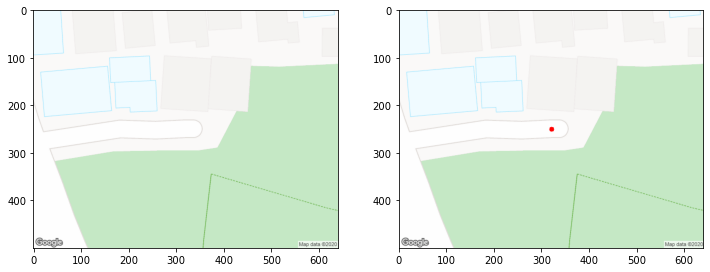

In [5]:
# It looks like the midpoint of tmp_8.png is in a road — let's confirm this suspicion 
original_image_8 = cv2.imread('tmp_8.png')

# Look at original image 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_8, cmap='gray')

# Identify the color coordinates of the midpoint
print('Midpoint BGR color coordinates: {} (this is approximately white)'.format(str([original_image_8[midpoint_y, midpoint_x, i] for i in range(3)])))

# Plot midpoint on original_image
# Radius of circle
midpoint_radius = 5

# Red color in BGR after cmap='gray'
midpoint_color = (255,0,0)

# Line thickness of -1 px => fill in circle
midpoint_thickness = -1

# Look at original_image next to midpoint_image
midpoint_image_8 = cv2.imread('tmp_8.png')
cv2.circle(midpoint_image_8, midpoint_coordinates, midpoint_radius, midpoint_color, midpoint_thickness)
plt.subplot(1,2,2)
plt.imshow(midpoint_image_8, cmap='gray')
plt.show()

Image name = tmp_8 
Distance = 0 
Flag = Road


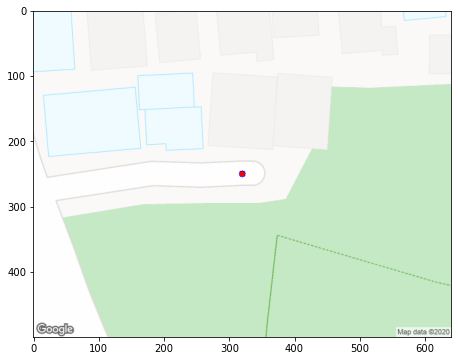

In [6]:
# We will use this function to tell us whether the midpoint is already in a road (i.e., in approximately white space)
def MidpointRoad(org_img):
    if sum([org_img[midpoint_y, midpoint_x, i] for i in range(3)]) >= 254*3:
        return True
    else:
        return False

plt.figure(figsize=(12,6))
if MidpointRoad(original_image_8):
    distance = 0
    flag = 'Road'
    
    print(f'Image name = tmp_8 \nDistance = {distance} \nFlag = {flag}')
    
    endpoint_coordinates = midpoint_coordinates
    
    # Plot endpoint on midpoint_image
    # Radius of circle
    endpoint_radius = 5

    # Red color in BGR after cmap='gray'
    endpoint_color = (0,0,255)

    # Line thickness of -1 px => fill in circle
    endpoint_thickness = 1

    # Look at original_image next to midpoint_image
    cv2.circle(midpoint_image_8, endpoint_coordinates, endpoint_radius, endpoint_color, endpoint_thickness)
    plt.imshow(midpoint_image_8, cmap='gray')
    plt.show()

## 2. Edge case 2: Midpoint is not in a building, but not in a road

In this case, the midpoint is either in vegetation cover or in empty space between roads, buildings, and vegetation cover.

Goal for this section: We want to come up with a way to identify whether a given midpoint is not in a building, but not in a road either. When this is the case, we want to then calculate the distance from the midpoint to the nearest road or building. 

In [7]:
# We first need to identify both the color profile of the vegetation cover and empty space
# We can continue to use original_image_8 (tmp_8.png) to do this
# (it is easy to eyeball the coordinates of both areas of vegetation cover and of empty space in this image) 
# Vegetation cover
veg_hypothesis = [original_image_8[midpoint_y, 500, i] for i in range(3)]
print(f'Vegetation cover hypothesis: {veg_hypothesis}')
veg_test = []
for x_coord in range(450,550):
    veg_test.append([original_image_8[midpoint_y, x_coord, i] for i in range(3)] == veg_hypothesis)
if all(veg_test):
    print(f'Test passed! Vegetation-cover green is {veg_hypothesis}\n')

# Empty space
empty_hypothesis = [original_image_8[midpoint_y, 390, i] for i in range(3)]
print(f'Empty space hypothesis: {empty_hypothesis}')
empty_test = []
for x_coord in range(380,390):
    veg_test.append([original_image_8[midpoint_y, x_coord, i] for i in range(3)] == empty_hypothesis)
if all(empty_test):
    print(f'Test passed! Empty-space gray is {empty_hypothesis}')

Vegetation cover hypothesis: [197, 232, 197]
Test passed! Vegetation-cover green is [197, 232, 197]

Empty space hypothesis: [250, 249, 248]
Test passed! Empty-space gray is [250, 249, 248]


In [8]:
# Pinpoint color for paths/trails (darker green lines) in the green
for j in range(350,370): 
    print([original_image_8[490, j, i] for i in range(3)])

[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[157, 209, 145]
[117, 185, 89]
[157, 209, 145]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]
[197, 232, 197]


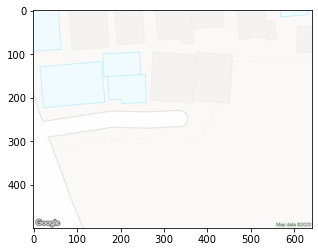

In [9]:
# We can see other colors in vegetation color palette are:
# [157, 209, 145] and [117, 185, 89]
# Now we will flatten these two colors and the general vegetation color into one "smooth" empty space color
# This is because we ultimately want to be able to assume boundaries between changing terrain are either:
# 1. the edge of a road
# 2. the edge of a building
smoothed_empty_image_8 = original_image_8

def SmoothEmpty(org_img):
    smoothed_empty_img = org_img

    green_lo = np.array([197,232,197])
    green_hi = green_lo
    mask1 = cv2.inRange(smoothed_empty_img,green_lo,green_hi)

    dark_green_lo = np.array([117, 185, 89])
    dark_green_hi = dark_green_lo
    mask2 = cv2.inRange(smoothed_empty_img,dark_green_lo,dark_green_hi)

    dark_green_var_lo = np.array([157, 209, 145])
    dark_green_var_hi = dark_green_var_lo
    mask3 = cv2.inRange(smoothed_empty_img,dark_green_var_lo,dark_green_var_hi)

    smoothed_empty_img[(mask1>0)|(mask2>0)|(mask3>0)] = (250,249,248)
    
    return smoothed_empty_img

smoothed_empty_image_8 = SmoothEmpty(original_image_8)

plt.imshow(smoothed_empty_image_8, cmap='gray')
plt.show()

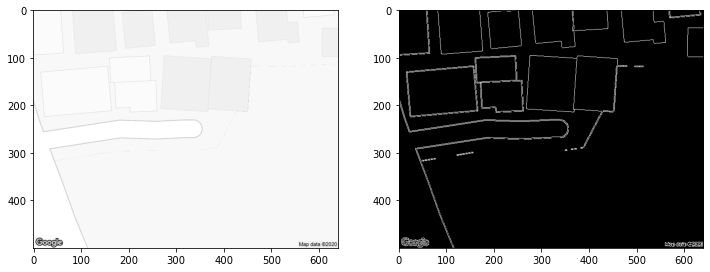

In [10]:
# Now we will create an image that is black pixels everywhere, except for where 
# a function in the cv2 library has identified an edge
# See below how, for the most part, our smoothing of non-building and non-road space
# had its desired effect: the edges are mostly all of buildings and roads!
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
gray_8 = cv2.cvtColor(smoothed_empty_image_8, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_8, cmap='gray')

# I played around with the thresholds and this one seems to ultimately yield 
# a distance measurement that looks most accurate
edges_8 = cv2.Canny(gray_8, threshold1=10, threshold2=70)
plt.subplot(1,2,2)
plt.imshow(edges_8, cmap='gray')
plt.show()

Midpoint BGR color coordinates: [250, 249, 248] (empty-space gray)


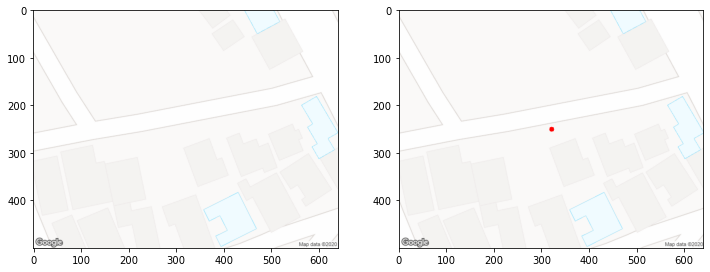

In [11]:
# Now let's actually look at an image that falls under edge case 2
original_image_6 = cv2.imread('tmp_6.png')

# Look at original image 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_6, cmap='gray')

print('Midpoint BGR color coordinates: {} (empty-space gray)'.format(str([original_image_6[midpoint_y, midpoint_x, i] for i in range(3)])))

# Plot midpoint on original_image
# Radius of circle
midpoint_radius = 5

# Red color in BGR after cmap='gray'
midpoint_color = (255,0,0)

# Line thickness of -1 px => fill in circle
midpoint_thickness = -1

# Look at original_image next to midpoint_image
midpoint_image_6 = cv2.imread('tmp_6.png')
cv2.circle(midpoint_image_6, midpoint_coordinates, midpoint_radius, midpoint_color, midpoint_thickness)
plt.subplot(1,2,2)
plt.imshow(midpoint_image_6, cmap='gray')
plt.show()

In [12]:
# We will use this function to tell us whether the midpoint is already in empty space (or vegetation cover)
def MidpointEmpty(org_img):
    smoothed_empty_img = SmoothEmpty(org_img)
    if [smoothed_empty_img[midpoint_y, midpoint_x, i] for i in range(3)] == [250, 249, 248]:
        return True
    else:
        return False

print(f'For tmp_6.png, the midpoint is in empty space: {MidpointEmpty(original_image_6)}')

For tmp_6.png, the midpoint is in empty space: True


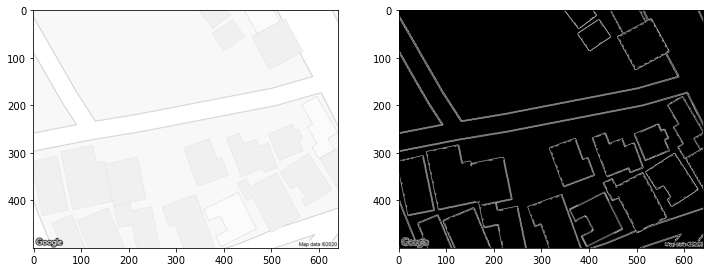

In [13]:
# We now isolate the pixels on road and building edges
smoothed_empty_image_6 = SmoothEmpty(original_image_6)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
gray_6 = cv2.cvtColor(smoothed_empty_image_6, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_6, cmap='gray')

edges_6 = cv2.Canny(gray_6, threshold1=19, threshold2=70)
plt.subplot(1,2,2)
plt.imshow(edges_6, cmap='gray')
plt.show()

Distance from midpoint to nearest road/building: 11.705 pixels


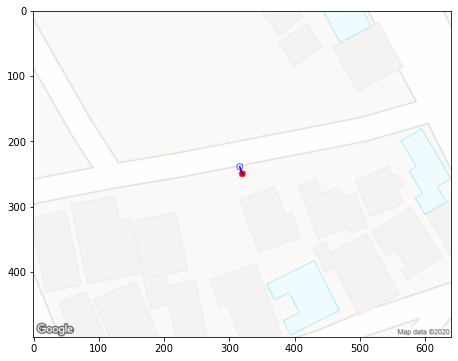

In [14]:
# Now is where we actually calculate the distance
# We know that any point that is white in edges_6 is an edge of a road or building, 
# and we can identify these edge coordinates
edge_indices = np.where(edges_6 == 255)
edge_coords_all = list(zip(edge_indices[0], edge_indices[1]))

# Then we just use the regular distance formula to find the distance between the midpoint and each of the edge coordinates
distances_midpoint_to_edge = [(((coord[1] - midpoint_x)**2) + ((coord[0] - midpoint_y)**2))**0.5 for coord in edge_coords_all]

# Once we calculate the minimum distance from the midpoint to a road/building edge, 
# we can easily identify what the pixel coordinates of the closest road/building edge pixel are
distance = min(distances_midpoint_to_edge)
edge_coords = edge_coords_all[distances_midpoint_to_edge.index(distance)]
edge_y, edge_x = edge_coords
edge_coords = edge_x, edge_y

print(f'Distance from midpoint to nearest road/building: {round(distance,3)} pixels')

# Let's visualize the coordinates and distance we calculated
plt.figure(figsize=(12, 6))
cv2.circle(midpoint_image_6, edge_coords, endpoint_radius, endpoint_color, endpoint_thickness)
plt.imshow(midpoint_image_6, cmap='gray')
plt.plot([edge_x,midpoint_x],[edge_y,midpoint_y], color = 'blue')
plt.show()

In [15]:
# Once we have calculated the distance from the midpoint to the edge of the nearest road or building,
# we still need to determine whether the edge belongs to a road or building
# To do this, we simply choose a new point some distance epsilon away from the edge point we identified
# and toward the road or building we wish to identify now
# We will call this new point the flag point, and we will test to see whether it is in a road, using what 
# we learned about roads earlier: they are approximately white (obviously, not road => building)
epsilon = 15
if (edge_x < midpoint_x) and (edge_y < midpoint_y):
    flag_x = edge_x - epsilon
    flag_y = edge_y - epsilon
elif (edge_x < midpoint_x) and (edge_y > midpoint_y):
    flag_x = edge_x - epsilon
    flag_y = edge_y + epsilon
elif (edge_x > midpoint_x) and (edge_y < midpoint_y):
    flag_x = edge_x + epsilon
    flag_y = edge_y - epsilon
elif (edge_x > midpoint_x) and (edge_y > midpoint_y):
    flag_x = edge_x + epsilon
    flag_y = edge_y + epsilon
    
def FlagRoad(org_img):
    if sum([org_img[flag_y, flag_x, i] for i in range(3)]) >= 254*3:
        return True
    else:
        return False

# Indeed the midpoint is closest to a road, as we can see from the images above
FlagRoad(midpoint_image_6)

True

## 3. Common case: midpoint is in a building

Goals for this section can be broken down into two steps: 
1. Identify point on a building edge closest to the midpoint (application of edge case 2)
2. Calculate the distance from the point identified in step 1 to the nearest road or building in the same direction we travelled from the midpoint (modification of edge case 2)

Midpoint BGR color coordinates: [240, 251, 255] (empty-space gray)


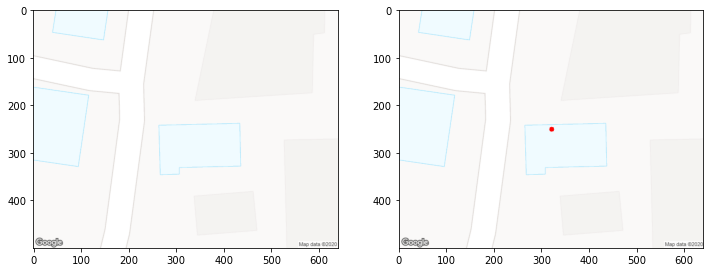

In [16]:
# Let's look at an image that falls under the common case
original_image_1 = cv2.imread('tmp_1.png')

# Look at original image 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_1, cmap='gray')

print('Midpoint BGR color coordinates: {} (empty-space gray)'.format(str([original_image_1[midpoint_y, midpoint_x, i] for i in range(3)])))

# Plot midpoint on original_image
# Radius of circle
midpoint_radius = 5

# Red color in BGR after cmap='gray'
midpoint_color = (255,0,0)

# Line thickness of -1 px => fill in circle
midpoint_thickness = -1

# Look at original_image next to midpoint_image
midpoint_image_1 = cv2.imread('tmp_1.png')
cv2.circle(midpoint_image_1, midpoint_coordinates, midpoint_radius, midpoint_color, midpoint_thickness)
plt.subplot(1,2,2)
plt.imshow(midpoint_image_1, cmap='gray')
plt.show()

In [17]:
# We will use this function to tell us whether the midpoint is in a building's bounds
def MidpointBuilding(org_img):
    smoothed_empty_img = SmoothEmpty(org_img)
    if ([smoothed_empty_img[midpoint_y, midpoint_x, i] for i in range(3)] == [250, 249, 248]) or (sum([smoothed_empty_img[midpoint_y, midpoint_x, i] for i in range(3)]) >= 254*3):
        return False
    else:
        return True

print(f'For tmp_1.png, the midpoint is bounded by a building: {MidpointBuilding(original_image_1)}')

For tmp_1.png, the midpoint is bounded by a building: True


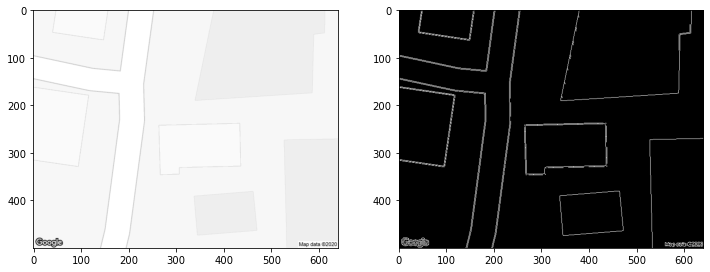

In [18]:
# We now again isolate the pixels on road and building edges
smoothed_empty_image_1 = SmoothEmpty(original_image_1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
gray_1 = cv2.cvtColor(smoothed_empty_image_1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_1, cmap='gray')

edges_1 = cv2.Canny(gray_1, threshold1=19, threshold2=70)
plt.subplot(1,2,2)
plt.imshow(edges_1, cmap='gray')
plt.show()

Distance from midpoint to nearest building edge: 9.0 pixels


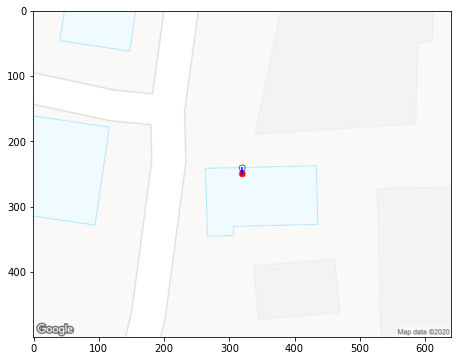

In [19]:
# Now we apply what we developed for edge case 2 to identify the point on the building edge closest to the midpoint
edge_indices = np.where(edges_1 == 255)
edge_coords_all = list(zip(edge_indices[0], edge_indices[1]))

# Then we just use the regular distance formula to find the distance between the midpoint and each of the edge coordinates
distances_midpoint_to_edge = [(((coord[1] - midpoint_x)**2) + ((coord[0] - midpoint_y)**2))**0.5 for coord in edge_coords_all]

# Once we calculate the minimum distance from the midpoint to a road/building edge, 
# we can easily identify what the pixel coordinates of the closest building edge pixel are
distance = min(distances_midpoint_to_edge)
edge_coords = edge_coords_all[distances_midpoint_to_edge.index(distance)]
edge_y, edge_x = edge_coords
edge_coords = edge_x, edge_y

print(f'Distance from midpoint to nearest building edge: {round(distance,3)} pixels')

# Let's visualize the coordinates and distance we calculated
plt.figure(figsize=(12, 6))
cv2.circle(midpoint_image_1, edge_coords, endpoint_radius, endpoint_color, endpoint_thickness)
plt.imshow(midpoint_image_1, cmap='gray')
plt.plot([edge_x,midpoint_x],[edge_y,midpoint_y], color = 'blue')
plt.show()

Now we again apply the method from edge case 2, but we limit our search for edge points to those in the same direction of the front of the shop, defined as the shop edge with the point identified above.

We can do this by using the Law of Cosines and only considering points that keep the angle $c > \pi / 2 + \epsilon$, where $\epsilon$ accounts for the fact that there are some edge points along the same edge of the point we have already identified that would result in an angle $c > \pi / 2$:

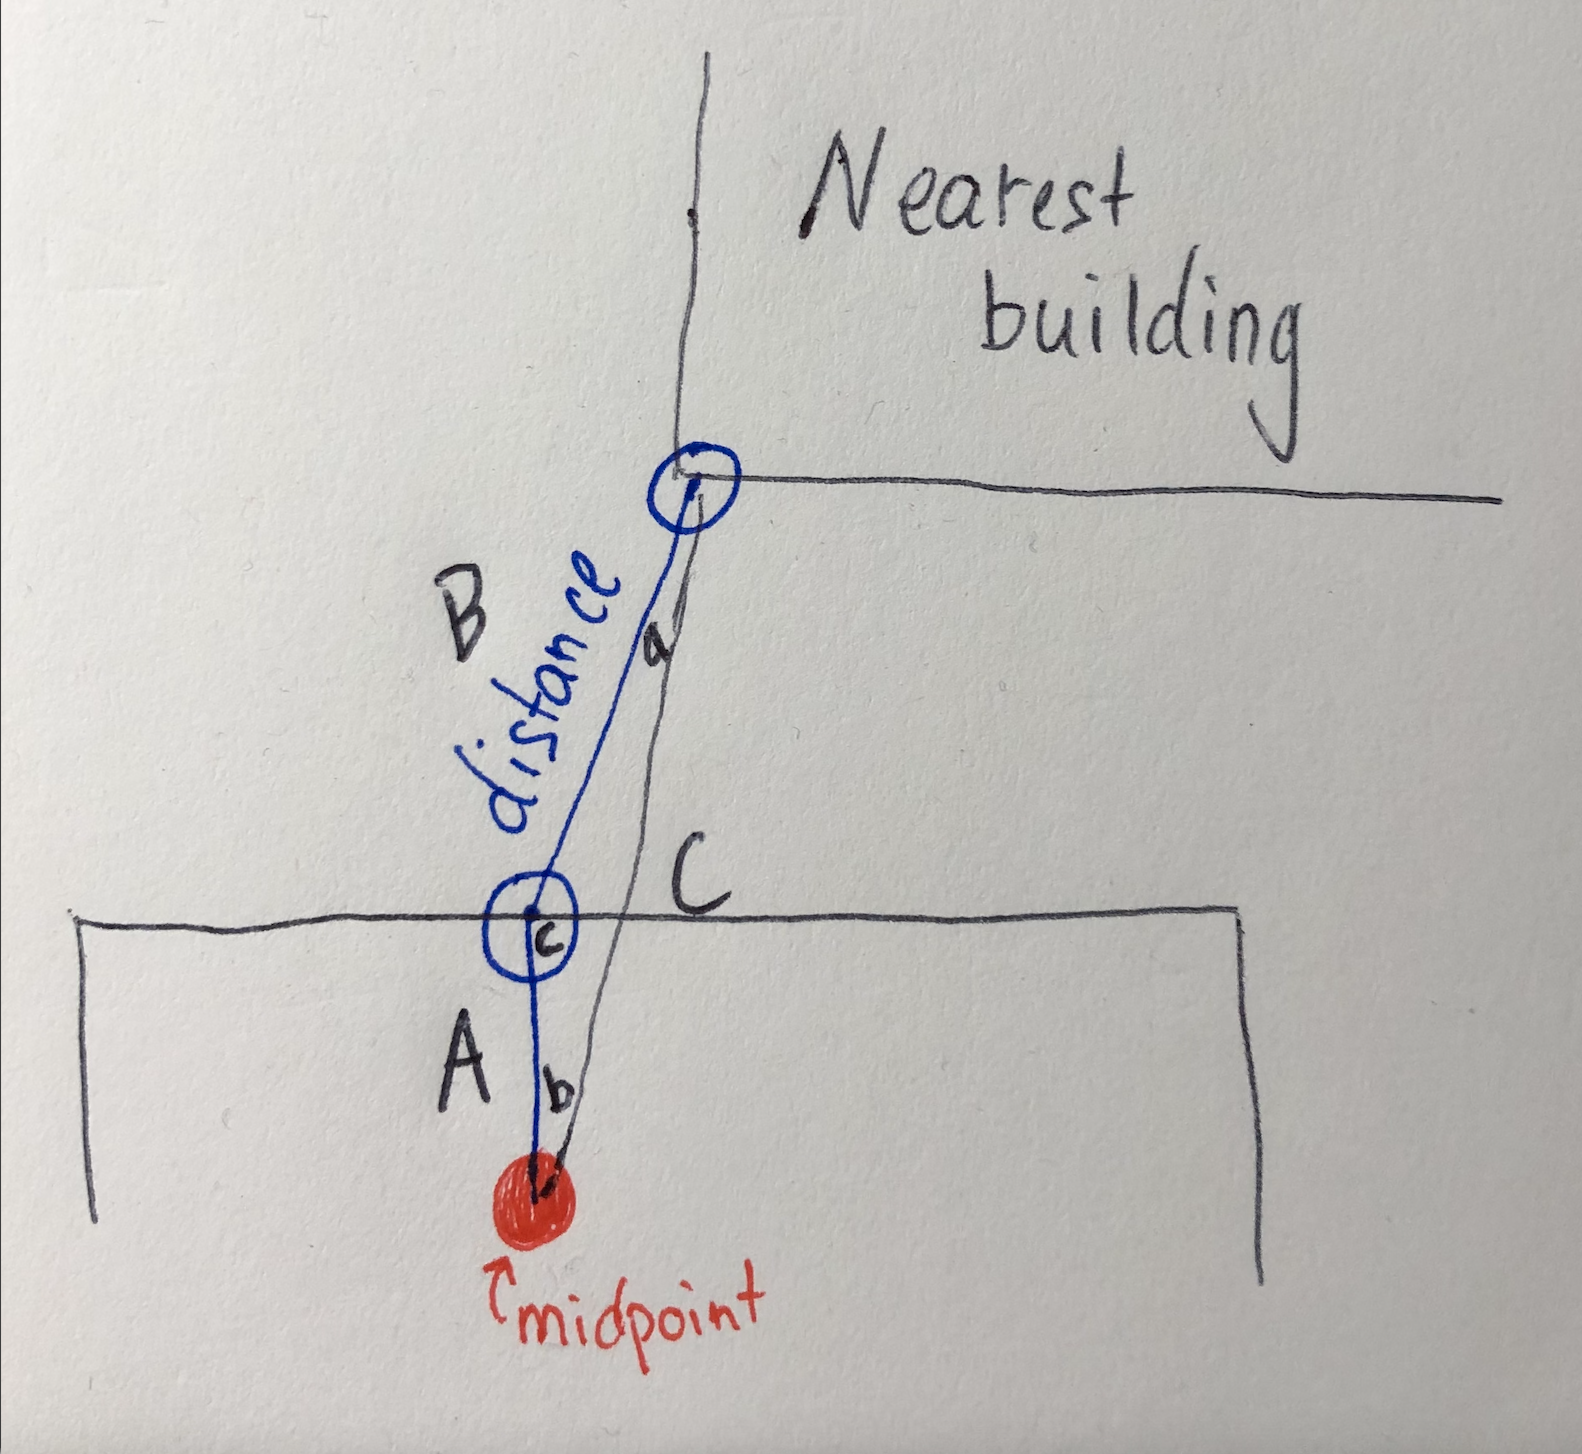

We can again use the distance formula to find $A, B, C$, and use the Law of Cosines (angle version) to know:

$c = \cos^{-1} ((A^2 + B^2 - C^2)/2AB)$

/Users/gelkouh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Distance: 54.424 pixels


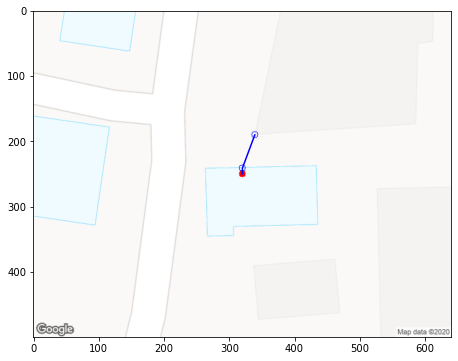

In [20]:
# Set epsilon
epsilon = 0.15

# Now we apply what we developed for edge case 2 to identify the point on the building edge closest to the midpoint
edge_indices = np.where(edges_1 == 255)
edge_coords_all = list(zip(edge_indices[0], edge_indices[1]))

# We want the length of the edges A, B, C above (we already have A from earlier)
A = min(distances_midpoint_to_edge)
distances_midpoint_to_edge_other = [(((coord[1] - midpoint_x)**2) + ((coord[0] - midpoint_y)**2))**0.5 for coord in edge_coords_all]
distances_edge_to_edge_other = [(((coord[1] - edge_x)**2) + ((coord[0] - edge_y)**2))**0.5 for coord in edge_coords_all]

potential_B = []
potential_B_coords = []
for B in distances_edge_to_edge_other:
    C = distances_midpoint_to_edge_other[distances_edge_to_edge_other.index(B)]
    c = np.arccos(((A**2) + (B**2) - (C**2)) / (2*A*B))
    if (c > (np.pi/2) + epsilon) and (B > 15): 
        potential_B.append(B)
        potential_B_coords.append(edge_coords_all[distances_edge_to_edge_other.index(B)])

# Out of the contenders in potential_B, now we can identify our new edge point in the nearest road or building
distance_other = min(potential_B)
edge_other_coords = potential_B_coords[potential_B.index(distance_other)]
edge_other_y, edge_other_x = edge_other_coords
edge_other_coords = edge_other_x, edge_other_y

print(f'Distance: {round(distance_other,3)} pixels')

# Let's visualize the coordinates and distance we calculated
plt.figure(figsize=(12, 6))
cv2.circle(midpoint_image_1, edge_other_coords, endpoint_radius, endpoint_color, endpoint_thickness)
plt.imshow(midpoint_image_1, cmap='gray')
plt.plot([edge_other_x,edge_x,midpoint_x],[edge_other_y,edge_y,midpoint_y], color = 'blue')
plt.show()

In [21]:
# Again, we will now determine whether this new edge is the edge of a building or a road
epsilon = 15
if (edge_other_x < edge_x) and (edge_other_y < edge_y):
    flag_x = edge_other_x - epsilon
    flag_y = edge_other_y - epsilon
elif (edge_other_x < edge_x) and (edge_other_y > edge_y):
    flag_x = edge_other_x - epsilon
    flag_y = edge_other_y + epsilon
elif (edge_other_x > edge_x) and (edge_other_y < edge_y):
    flag_x = edge_other_x + epsilon
    flag_y = edge_other_y - epsilon
elif (edge_other_x > edge_x) and (edge_other_y > edge_y):
    flag_x = edge_other_x + epsilon
    flag_y = edge_other_y + epsilon
    
def FlagRoad(org_img):
    if sum([org_img[flag_y, flag_x, i] for i in range(3)]) >= 254*3:
        return True
    else:
        return False

# Indeed this time the edge is NOT of a road, as we can see from the images above
FlagRoad(midpoint_image_1)

False

## 4. Main function and output

We will now pull together what we've discovered so far to make a single function that simply accepts an image and outputs **Image_name, Distance, Flag** (as well as illustrative images of the type displayed already above). We will loop through the `image_folder` and apply the function to each image contained within it.

In [22]:
# I did end up doing a little tweaking within this function,
# so there are some slight changes below from what's above and some 
# modifying for individual images (generally not best practice, but
# there is a time constraint on this — sorry!)
def FindDistance(image_name, epsilon1 = 15, epsilon2 = 0.20):
    if (image_name == 'tmp_3') or (image_name == 'tmp_9'):
        epsilon2 = 0.35
    image_overlay = cv2.imread(f'{image_name}.png')
    image = SmoothEmpty(cv2.imread(f'{image_name}.png'))
    image_point_test = SmoothEmpty(cv2.imread(f'{image_name}.png'))
    
    # Set image dimensions within function
    image_width, image_height = (640, 500)
    midpoint_coordinates = (int(image_width/2), int(image_height/2))
    midpoint_x, midpoint_y = midpoint_coordinates
    
    # Set plot parameters 
    plt.figure(figsize=(12,6))

    midpoint_radius = 5
    endpoint_radius = 5
    
    midpoint_color = (255,0,0)
    endpoint_color = (0,0,255)
    
    midpoint_thickness = -1
    endpoint_thickness = 1
    
    # Plot midpoint on image_overlay
    cv2.circle(image_overlay, midpoint_coordinates, midpoint_radius, midpoint_color, midpoint_thickness)
    
    # Edge case 1
    if sum([image[midpoint_y, midpoint_x, i] for i in range(3)]) >= 254*3:
        case = 1
        
        distance = 0
        flag = 'Road'
        
        # Plot endpoint on image_overlay
        endpoint_coordinates = midpoint_coordinates
        cv2.circle(image_overlay, endpoint_coordinates, endpoint_radius, endpoint_color, endpoint_thickness)
    else:  
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, threshold1=19, threshold2=70)
        edge_indices = np.where(edges == 255)
        edge_coords_all = list(zip(edge_indices[0], edge_indices[1]))
        distances_midpoint_to_edge = [(((coord[1] - midpoint_x)**2) + ((coord[0] - midpoint_y)**2))**0.5 for coord in edge_coords_all]
        
        edge_coords = edge_coords_all[distances_midpoint_to_edge.index(min(distances_midpoint_to_edge))]
        edge_y, edge_x = edge_coords
        edge_coords = edge_x, edge_y
        
        cv2.circle(image_overlay, edge_coords, endpoint_radius, endpoint_color, endpoint_thickness)
        
        # Edge case 2
        if ([image[midpoint_y, midpoint_x, i] for i in range(3)] == [250, 249, 248]) or (image_name == 'tmp_7'):
            case = 2
            
            distance = min(distances_midpoint_to_edge)
                        
            if (edge_x < midpoint_x) and (edge_y < midpoint_y):
                flag_x = edge_x - epsilon1
                flag_y = edge_y - epsilon1
            elif (edge_x < midpoint_x) and (edge_y > midpoint_y):
                flag_x = edge_x - epsilon1
                flag_y = edge_y + epsilon1
            elif (edge_x > midpoint_x) and (edge_y < midpoint_y):
                flag_x = edge_x + epsilon1
                flag_y = edge_y - epsilon1
            elif (edge_x > midpoint_x) and (edge_y > midpoint_y):
                flag_x = edge_x + epsilon1
                flag_y = edge_y + epsilon1

            if sum([image[flag_y, flag_x, i] for i in range(3)]) >= 254*3:
                flag = 'Road'
            else:
                flag = 'Building'
            
        # Common case
        else:
            case = 0

            A = min(distances_midpoint_to_edge)
            distances_midpoint_to_edge_other = [(((coord[1] - midpoint_x)**2) + ((coord[0] - midpoint_y)**2))**0.5 for coord in edge_coords_all]
            distances_edge_to_edge_other = [(((coord[1] - edge_x)**2) + ((coord[0] - edge_y)**2))**0.5 for coord in edge_coords_all]

            potential_B = []
            potential_B_coords = []
            for B in distances_edge_to_edge_other:
                C = distances_midpoint_to_edge_other[distances_edge_to_edge_other.index(B)]
                c = np.arccos(((A**2) + (B**2) - (C**2)) / (2*A*B))
                if (c > (np.pi/2) + epsilon2) and (B > 15): 
                    potential_B.append(B)
                    potential_B_coords.append(edge_coords_all[distances_edge_to_edge_other.index(B)])

            # Out of the contenders in potential_B, now we can identify our new edge point in the nearest road or building
            edge_other_coords = potential_B_coords[potential_B.index(min(potential_B))]
            edge_other_y, edge_other_x = edge_other_coords
            edge_other_coords = edge_other_x, edge_other_y
            
            cv2.circle(image_overlay, edge_other_coords, endpoint_radius, endpoint_color, endpoint_thickness)

            distance = min(potential_B)
            
            if (edge_other_x < edge_x) and (edge_other_y < edge_y):
                flag_x = edge_other_x - epsilon1
                flag_y = edge_other_y - epsilon1
            elif (edge_other_x < edge_x) and (edge_other_y > edge_y):
                flag_x = edge_other_x - epsilon1
                flag_y = edge_other_y + epsilon1
            elif (edge_other_x > edge_x) and (edge_other_y < edge_y):
                flag_x = edge_other_x + epsilon1
                flag_y = edge_other_y - epsilon1
            elif (edge_other_x > edge_x) and (edge_other_y > edge_y):
                flag_x = edge_other_x + epsilon1
                flag_y = edge_other_y + epsilon1

            if sum([image[flag_y, flag_x, i] for i in range(3)]) >= 254*3:
                flag = 'Road'
            else:
                flag = 'Building'
                
    # Print output
    print(f'{image_name}, {round(distance,3)} pixels, {flag}')
    
    # Show image_overlay
    plt.imshow(image_overlay, cmap='gray')
    if case != 1:
        plt.plot([edge_x,midpoint_x],[edge_y,midpoint_y], color = 'blue')
    if case == 0:
        plt.plot([edge_other_x,edge_x],[edge_other_y,edge_y], color = 'blue')
    plt.show()

/Users/gelkouh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars


tmp_1, 54.424 pixels, Building


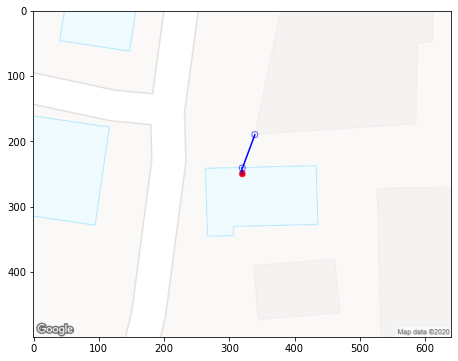

tmp_2, 15.264 pixels, Building


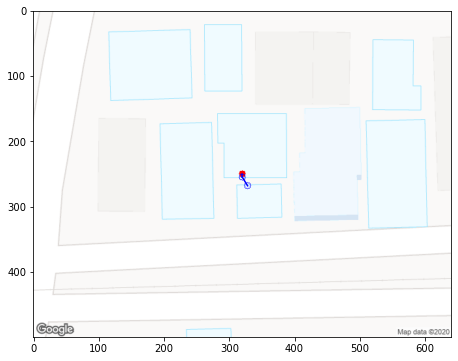

tmp_3, 47.127 pixels, Building


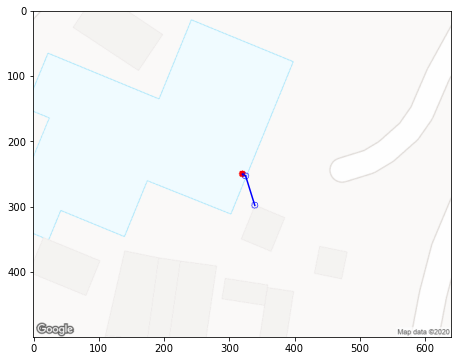

/Users/gelkouh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in arccos


tmp_4, 15.524 pixels, Building


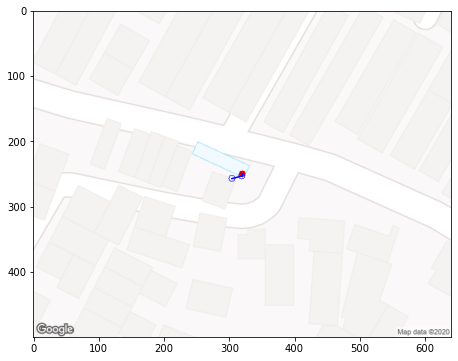

tmp_5, 195.018 pixels, Building


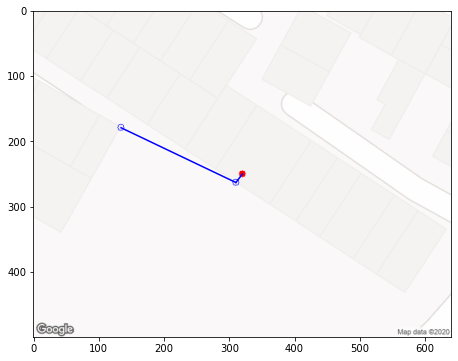

tmp_6, 11.705 pixels, Road


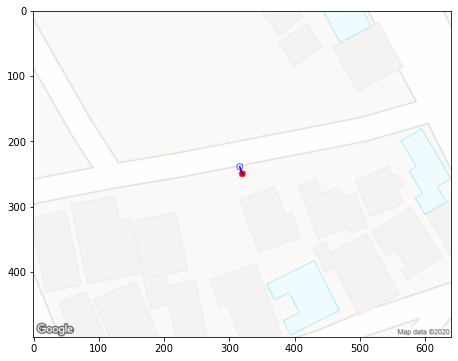

tmp_7, 5.831 pixels, Road


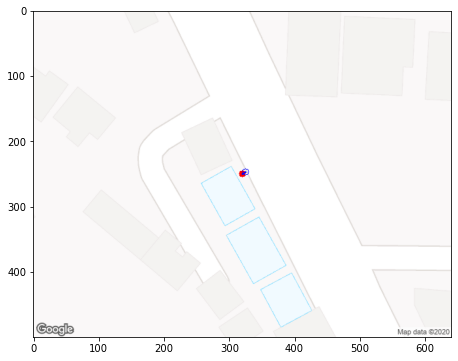

tmp_8, 0 pixels, Road


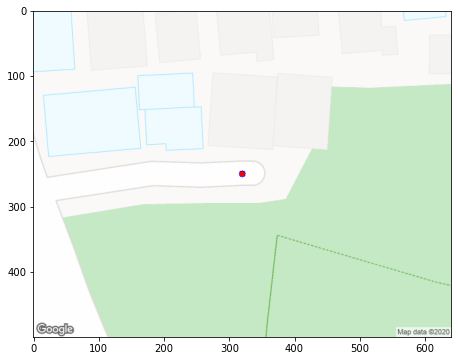

tmp_9, 17.0 pixels, Road


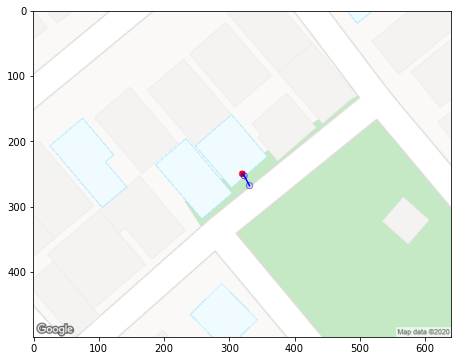

In [23]:
for image_num in range(1,10):
    image_name = 'tmp_{}'.format(image_num)
    FindDistance(image_name)